# <center> Прогнозирование цен на недвижимость методами машинного обученния <center>

<center> <img src = https://catalog-777.com/upload/prognoz.jpeg alt="drawing" style="width:400px;">

## <center>  Содержание файла: <center>
1. Описание проекта
2. Описание данных
3. Подключение бибиотек
4. Функции, используемые в коде
5. Загрузка, очистка и разведывательный анализ данных
   1. Загрузка данных
   2. Обработка пропусков
   3. Создание новых признаков
   4. Обработка выбросов данных
6. Исследование данных
7. Создание модели
   1. Модель линейной регрссии
   2. Модель полиномиальной регресии
   3. Модель случайного леса и оптимизация гиперпараметров
8. Заключение

## 1. Описание проекта

Разработка модели для агентства недвижимости с целью увеличения скорости и качества совершения сделок путем прогнозирования стоимости недвижимости методами машинного обученияю

Проект состоит из следующих этапов:
1. Загрузка, разведывательный анализ и обработка данных.
2. Выделение наиболее значимых факторов, влияющих на стоимость недвижимости.
3. Построение модели для прогнозирования стоимости недвижимости.


## 2. Описание данных

* 'status' — статус
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

## 3. Подключение библиотек

In [179]:
# Общие библиотеки
import pandas as pd
import numpy as np
import ast
import sklearn
import re

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для создания модели
import category_encoders as ce
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble #ансамбли
import optuna
from sklearn.model_selection import cross_val_score

## 4. Функции, используемые в коде

In [180]:
def bed_count (col):
    
    '''
    Функция для орпеделения количества спален в объекте недвижимости:
    Принимает на вход колонку, содержащую информацию о количестве спален (col)
    Возвращает список с количеством спален по каждому объекту (beds_new)
    '''
    
    key_words = ['Beds', 'Bedrooms', 'bd']
    key_words_2 = ['acre', 'acres']
    key_words_3 = ['sqft']
    
    col = col.str.replace(',', '.')
    beds_new = []
    
    for el in col:
        
        a = 10000000
        
        if str(el).isdigit():
            a = int(el)       

        # Критерий 'Baths' предположительно означает спальню с ванной комнатой внутри, поэтому обозначим 'Baths' за 1 
        if 'Baths' in str(el) or 'Bath' in str(el):
            a = '1'

        for i, j in enumerate(str(el).split(' ')):
            
            if str(j) in key_words:
                if str(el).split(' ')[i-1].isdigit():
                    a = str(el).split(' ')[i-1]
                    break
            # Перевод акров в местры квадратные и деление на 10 (считаем, что средняя площадь комнаты 10 м2)
            elif str(j) in key_words_2:
                if re.fullmatch(pattern=r"\d+[.]\d+", string=str(el).split(' ')[i-1]):
                    a = (float(str(el).split(' ')[i-1])*43560) // 10
                    break
                if str(el).split(' ')[i-1].isdigit():
                    a = float(str(el).split(' ')[i-1])*43560 // 10
                    break
            # Перевод Квадратных метров в количество комнат целочисленным делением на 10
            elif str(j) in key_words_3:
                if re.fullmatch(pattern=r"\d+[.]\d+", string=str(el).split(' ')[i-1]):
                    a = (float(str(el).split(' ')[i-1])) // 10
                    break
                if str(el).split(' ')[i-1].isdigit():
                    a = float(str(el).split(' ')[i-1]) // 10
                    break
            
        if el == 10000000 and el is not np.NAN:
            a = el
        
        if el is np.NAN:
            a = np.NAN
        
        #if re.search(r'\bNo Data\b', str(el)):
          # a = np.NAN

        beds_new.append(a)
    
    return beds_new

In [181]:
def bath_count (col):
    
    '''
    Функция для орпеделения количества ванных в объекте недвижимости:
    Принимает на вход колонку, содержащую информацию о количестве ванных (col)
    Возвращает список с количеством ванных по каждому объекту (baths_new)
    '''
    
    col = col.str.replace(',', '.')
    baths_new = []
    
    key_words = ['Baths']
    
    # Данные ключи сформированы исходя из исхождных данных и частоты повторения в них критериев
    num_words = {'One' : 1, 'Two' : 2, 'Three' : 3, 'Bathrooms: 2' : 2}
    
    for el in col:
        
        a = 10000000
        
        if str(el).isdigit():
            a = int(el)
        
        if re.fullmatch(pattern=r"\d+[,]\d+", string=str(el)):
            el = el.str.repace(',', '.')
            a = float(el)
            
        if re.fullmatch(pattern=r"\d+[.]\d+", string=str(el)):
            a = float(el)
        
        else:
            for i, j in enumerate(str(el).split(' ')):
                
                if str(j) in key_words:
                    if str(el).split(' ')[i-1].isdigit():
                        a = str(el).split(' ')[i-1]
            
                elif str(j) in num_words.keys():
                    a = str(num_words[j])
                 
        if str(el) in num_words.keys():
            a = num_words[str(el)]
            
        if a == 10000000 and el is not np.NAN:
            a = 0
        
        if el is np.NAN:
            a = '0'

        baths_new.append(a)   
            
    return baths_new

In [182]:
def homeFacts(col):

    '''
    Функция для обработки критериев дома:
    Принимает на вход колонку, содержащую информацию о доме (col)
    Возвращает список со списками по соответствующим критерия. Если критерий прописан - его значение, если нет - nanу (homeFacts_list)
    '''

#Список критериев  
    homeFacts_crit = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize','Price/sqft']
    
    #Задание выходного списка
    homeFacts_list = []

    for i in homeFacts_crit:

        new_crit = []
        
        for el in col:
            el_1 = ast.literal_eval(el)

            for home_dict in el_1.values():

                for j in home_dict:

                    if j['factLabel'] == i:
                        crit_val = j['factValue']

                new_crit.append(crit_val)
        
        homeFacts_list.append(new_crit)

    homeFacts_list
    
    return homeFacts_list

In [183]:
def sqft_count (col):
    '''
    Функция для определения площади объекта:
    Принимает на вход колонку, содержащую информацию о площади (col)
    Возвращает список с площадями (sqft_new)
    '''
    
    col = col.str.replace(',', '')
    sqft_new = []
    
    key_words = ['sqft']
    
    # Данные ключи сформированы исходя из исхождных данных и частоты повторения в них критериев
    num_words = {'610-840 sqft' : 725}
    
    for el in col:
        
        a = 10000000
        
        if str(el).isdigit():
            a = int(el)
        
        else:
            #el = el.replace(',', '')
            for i, j in enumerate(str(el).split(' ')):
                
                if str(j) in key_words:
                    if str(el).split(' ')[i-1].isdigit():
                        a = str(el).split(' ')[i-1]
                        break
            
                elif str(j) in num_words.keys():
                    a = str(num_words[j])
                 
        if str(el) in num_words.keys():
            a = num_words[str(el)]
            
        if a == 10000000 and el is not np.NAN:
            a = el
        
        if el is np.NAN:
            a = np.NAN
            
        sqft_new.append(a)   
    
    sqft_new = pd.Series(sqft_new).apply(lambda x: np.NAN if re.search(r'\bsqft\b', str(x)) else x)        
    return sqft_new

In [184]:
def lotsize_count (col):
    
    '''
    Функция для определения придомовой площади:
    Принимает на вход колонку, содержащую информацию о площади (col)
    Возвращает список с площадями (sqft_new)
    '''
    
    col = col.str.replace(',', '')
    sqft_new = []
    
    key_words = ['sqft', 'Sq.']
    key_words_2 = ['acres', 'Acres', 'acre lot', 'Acre', 'acre']
    
    
    for el in col:
        
        a = 10000000
        
        if str(el).isdigit():
            a = int(el)
            
        else:
            #el = el.replace(',', '')
            for i, j in enumerate(str(el).split(' ')):
                
                if str(j) in key_words:
                    if str(el).split(' ')[i-1].isdigit():
                        a = str(el).split(' ')[i-1]
                        break
  
                elif str(j) in key_words_2:
                    if re.fullmatch(pattern=r"\d+[.]\d+", string=str(el).split(' ')[i-1]):
                        a = float(str(el).split(' ')[i-1])*43560
                        break
                    if str(el).split(' ')[i-1].isdigit():
                        a = str(el).split(' ')[i-1]
                        break
            
        if a == 10000000 and el is not np.NAN:
            a = el
        
        if el is np.NAN:
            a = np.NAN
        
        if re.search(r'\bNo Data\b', str(el)):
           a = np.NAN
            
        sqft_new.append(a)   
    
    sqft_new = pd.Series(sqft_new).apply(lambda x: np.NAN if re.search(r'\bsqft\b', str(x)) else x)        
    return sqft_new

In [185]:
def school_info(col):
    
    '''
    Функция для определения количества школ и среднего расстояния до них для каждого объекта
    На вход принимается колонка с информацией о школе
    Функция возвращает 2 списка: среднее расстояние до школы для каждого объекта и количество школ вокруг объекта
    В случае отсутствие информации в данные вставляется 0
    '''
    
    school_mean_dist_list = []
    school_count_list = []

    for el in col:
        el = ast.literal_eval(el)
        el = dict(el[0])

        school_count_list.append(len(el['rating']))
        school_data = dict(el['data'])
        
        sum_dist = 0
        len_dist = 0
        
        for i in school_data['Distance']:
            sum_dist += float(i.replace('mi', ''))
            len_dist += 1
        if len_dist == 0:
            school_mean_dist_list.append(0)
        else:
            school_mean_dist_list.append(sum_dist/len_dist)
            
    return school_mean_dist_list, school_count_list

In [186]:

def outliers_z_score(data, feature, log_scale=False):
    '''
    Функция для обработки выбросов методом z-отклонений
    '''
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 4.5 * sigma
    upper_bound = mu + 8 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

## 5. Загрузка, очистка и разведывательный анализ данных

### 5.1. Загрузка данных

In [187]:
data = pd.read_csv('data.csv')
data.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Исходный Датасет содержит в себе 18 признаков (включая целевой), все признаки являются типом "object". В данных содержатся пропуски, ниже по колонкам определим их количество в процентах.

In [189]:
data.isnull().sum()/len(data)*100

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.662221
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.958111
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

На первый взгляд в данных большое количество пропусков. Однако за некоторыми пропусками скорее всего стоит отсутствие того или иного фактора в квартире. Также есть дублирующие колонки о наличии бассейна и mls-id, их также необходимо объединить в одну. 
Наличие или отсутствие того или иного фактора в дальнейшем переведем в числовой признак следующим образом: 1 - наличие фактора в квартире, 0 - отсутствие фактора в квартире.

Определим количество дублирующих записей и избавимся от них

In [190]:
dupl_columns = list(data.columns)
duplicates = data[data.duplicated(subset=dupl_columns)]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

data = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {data.shape[0]}')

Число найденных дубликатов: 50
Результирующее число записей: 377135


### 5.2. Обработка пропусков

В настоящем разделе внимание уделено обработке пропусков, в некоторых признаках произведено проектирование новых данных

_Данные о наличии/отсутствии камина_

In [191]:
#Подсчет процента данных в которых указано наличие камина без их количества
(data[data['fireplace'] == 'Yes']['fireplace'].count() + data[data['fireplace'] == 'yes']['fireplace'].count())/len(data['fireplace'])*100

18.881567608416084

Так как в данных с каминами 20% данных составляют значения, где указано просто наличие камина без их количества, а еще 72% данных отсутствуют, то из дальнейшего анализа будет исключно количество каминов и их описание, оставляем только признак, содержащий наличие/отсутствие камина с учетом того, что в некоторых случаях указано "No" и "Not Applicable", в этом случае поставим 0. 

In [192]:
# Замена пропусков в данных с каминами 0
data['fireplace'] = data['fireplace'].fillna(0)

# Замена строк в колонке с каминами со значениями "No" и "Not Applicable" в данных с каминами 0
data.loc[data['fireplace'] == 'No', 'fireplace'] = 0
data.loc[data['fireplace'] == 'Not Applicable', 'fireplace'] = 0

# Замена оставшихся строк в колонке с каминами на 1
data['fireplace'] = data['fireplace'].apply(lambda x: 1 if x != 0 else 0)

_Данные о наличии/отсутствии бассейна_

In [193]:
# объединяем столбцы с бассейнами и вводим бинарный признак, удаляем исходные столбцы
data["privatePool"] = data["private pool"].fillna(data["PrivatePool"])
data['privatePool'] = data['privatePool'].apply(lambda x: 1 if x == 'yes' else 0)
data = data.drop(columns=['private pool', 'PrivatePool'])

_Данные о системе мультилистинга_

In [194]:
# объединяем столбцы с  идентификатором MLS
data["MlsId"] = data["MlsId"].fillna(data["mls-id"])
data = data.drop(columns=['mls-id'])

# Объявления, в которых отсутствует идентификатор MLS, будем считать не участвующими в системе мультилистинга, присваиваем пропускам значение 0
data['MlsId'] = data['MlsId'].fillna(0)

_Данные о количестве ванных комнат_

In [195]:
data["bath_count"] = bath_count(data["baths"])
data['bath_count'] = data['bath_count'].fillna(0)
data['bath_count'] = data['bath_count'].apply(lambda x: float(x))
data = data.drop(columns=['baths'])

_Данные о площади квартиры_

In [196]:
data['sqft'] = sqft_count(data['sqft'])
data['sqft'] = data['sqft'].apply(lambda x: np.NAN if '-' in str(x) else x)
sqft_median = data[data['sqft'] != np.NAN ]['sqft'].median()
data['sqft'] = data['sqft'].fillna(sqft_median)
data['sqft'] = data['sqft'].astype(float)

_Данные о количестве спален_

In [197]:
beds_new = pd.Series(bed_count(data['beds']))
beds_new = beds_new.fillna(0)
beds_new = beds_new.astype(float)
data['beds'] = beds_new

_Данные о cтатусе квартиры_

Исправим все дубликаты исходя из брифа. Проведем следующие замены:
* 'foreclosed' = 'foreclosure';
* 'pre foreclosure' = 'pre foreclosure auction';
* 'under contract showing' = 'under contract show' = 'under contract' = 'active under contract';
* 'under contract backups' = 'active backup' = 'backup contract';
* 'active auction' = 'auction active' = 'auction'.

In [198]:
# Исправление дубликатов
data['status'] = data['status'].apply(lambda x: 'Active' if x == 'for sale' or x == 'For Sale' or x == 'For sale' else x)
data['status'] = data['status'].apply(lambda x: 'foreclosed' if x == 'foreclosure' else x)
data['status'] = data['status'].apply(lambda x: 'pre foreclosure' if x == 'pre foreclosure auction' else x)
data['status'] = data['status'].apply(lambda x: 'under contract' if x == 'under contract showing' or 
                                      x == 'under contract show' or 
                                      x == 'active under contract' else x)
data['status'] = data['status'].apply(lambda x: 'active backup' if x == 'under contract backups' or 
                                      x == 'backup contract' else x)
data['status'] = data['status'].apply(lambda x: 'auction' if x == 'auction active' or 
                                      x == 'active auction' else x)


# В объявлениях со статусом "Coming soon: ________" будем считать дату неважной, во всех объявнениях внесем "Coming soon"
data['status'] = data['status'].apply(lambda x: 'Coming soon' if 'Coming soon' in str(x) else x)

# В объявлениях в пропусками статуса внесем информацию об отсутствии статуса
data["status"] = data["status"].fillna('no status')

In [199]:
status_list = data['status'].value_counts()[:10].index.to_list()
data['status'] = data['status'].apply(lambda x: x if x in status_list else 'other')

_Данные о типе объекта недвижимости_

Исправим все дубликаты исходя из брифа. Проведем следующие замены:
* 'manufactured home (house)' = 'mobile' = 'prefab' = 'modular';
* 'mobile' = 'mo2 le' = 'mo2le';
* 'cabin' = 'ca2 n' = 'ca2n';
* midcentury = mid century = mid-century;
* single family = single-family home.


In [200]:
mobile = ['manufactured home (house)', 'mobile', 'prefab', 'modular', 'mo2 le', 'mo2le']
data['propertyType'] = data['propertyType'].apply(lambda x: 'mobile' if str(x).lower() in mobile else x)

cabin = ['cabin', 'ca2 n', 'ca2n']
data['propertyType'] = data['propertyType'].apply(lambda x: 'cabin' if str(x).lower() in cabin else x)

midcentury = ['midcentury', 'mid century', 'mid-century']
data['propertyType'] = data['propertyType'].apply(lambda x: 'midcentury' if str(x).lower() in midcentury else x)

single_family = ['single family', 'single-family home', 'single family home']
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family' if str(x).lower() in single_family else x)

# В объявлениях в пропусками статуса внесем информацию об отсутствии информации
data["propertyType"] = data["propertyType"].fillna('no information')


In [201]:
propertyType_list = data['propertyType'].value_counts()[:10].index.to_list()
data['propertyType'] = data['propertyType'].apply(lambda x: x if x in propertyType_list else 'other')

_Данные об этаже_

Так как почти в 40% данных отсутствует информация об этажности, а вставка медианного или прочего значения скорее навредит прогнозированию, данный признак будет удален из дальнейшего исследования.

In [202]:
data = data.drop(columns=['stories'], axis=1)

Посмотрим на количество пропусков

In [203]:
data.isnull().sum()/len(data)*100

status          0.000000
propertyType    0.000000
street          0.000530
homeFacts       0.000000
fireplace       0.000000
city            0.009015
schools         0.000000
sqft            0.000000
zipcode         0.000000
beds            0.013258
state           0.000000
MlsId           0.000000
target          0.657589
privatePool     0.000000
bath_count      0.000000
dtype: float64

Учитывая незначительное количество пропусков в оставшихся данных - удалим строки, содержащие пропуски

In [204]:
data = data.dropna()

### 5.3. Создание новых признаков

_Данные о доме_

In [205]:
# С помощью функции находим критерии дома и списки с данными по этим критериям
homeFacts_list = homeFacts(data['homeFacts'])

homeFacts_crit = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize','Price/sqft']

# Создаем новые признаки на основе полученных списков
for i, el in enumerate(homeFacts_crit):
    data[el] = homeFacts_list[i]

data = data.drop(columns=['homeFacts'])

In [206]:
# Перевод признаков с данными об отоплении, кондиционировании парковке и о реконструкции в бинарные признаки (0 - отсутствие, 1 - наличие)
data['Remodeled year'] = data['Remodeled year'].apply(lambda x: 0 if x is np.NAN 
                                                      or x == ''
                                                      else 1)

data['Heating'] = data['Heating'].apply(lambda x: 0 if x is np.NaN
                                        or x == ''
                                        or x == 'No Data'
                                        or x == 'No Info'
                                        else 1)
data['Cooling'] = data['Cooling'].apply(lambda x: 0 if x is np.NAN 
                                        or x == 'No Data' 
                                        or x == 'No Info'  
                                        else 1)
data['Parking'] = data['Parking'].apply(lambda x: 0 if x is np.NAN 
                                        or x == 'No Data' 
                                        or x == 'No Info'  
                                        else 1)

In [207]:
data['lotsize'] = pd.Series(lotsize_count(data['lotsize']))
data['lotsize'] = data['lotsize'].apply(lambda x: np.NAN if '—' in str(x)
                  or x == '' 
                  else x)
lotsize_median = data['lotsize'].median()
data['lotsize'] = data['lotsize'].fillna(lotsize_median)
data['lotsize'] = data['lotsize'].apply(lambda x: float(x))

Предположительно год дома может оказывать сильное влияние на ценообразование, поэтому медианным значением заполнять не будет. вместо пропусков вставим 0, а далее посмотрим на возможность удаление этого признака.

In [208]:
data['Year built'] = data['Year built'].fillna('0')
data['Year built'] = data['Year built'].apply(lambda x: 0 if x == 'No Data'
                                              or x == 'No Info' 
                                              or x == '' else x)
data['Year built'] = data['Year built'].astype(float)

In [209]:
# Предобработка данных по относительной стоимости квартиры
data['Price/sqft'] = data['Price/sqft'].str.replace('$', '')
data['Price/sqft'] = data['Price/sqft'].str.replace(',', '')
data['Price/sqft'] = data['Price/sqft'].str.replace('/sqft', '')
data['Price/sqft'] = data['Price/sqft'].str.replace('/ Sq. Ft.', '')

# Создаем пропуски в строках с указанием об отсутствии информации 
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: np.NAN if x == 'No Info'
                                              or x == 'No Data'
                                              or x == 'Contact manager'
                                              or x == '' 
                                              else x)

# Преобразуем признак в численный и заполняем пропуски медианным значением
data['Price/sqft'] = data['Price/sqft'].astype(float)
data['Price/sqft'] = data['Price/sqft'].fillna(data['Price/sqft'].median())

_Данные о школе_

In [210]:
data['school_mean_dist'], data['school_count'] = school_info(data['schools'])
data = data.drop(columns=['schools'], axis = 1)

_Данные о мультилистинговой системе_

In [211]:
# Данные о мультилистинговой системе представим в бинарном виде: 0 - отсутствие системы, 1 - наличие
data['MlsId'] = data['MlsId'].apply(lambda x: 0 if x == '0' or x == 0
                                    or x == 'NO MLS' or x == 'No MLS #' 
                                    or x == 'No' or x == 'No mls' or x == 'No '
                                    or x == 'No MLS' or x == 'No MLS#'
                                    or x == 'No  MLs #' else 1)

_Данные целевого признака_

In [212]:
data['target'] = data['target'].str.replace('$', '')
data['target'] = data['target'].str.replace(',', '')
data['target'] = data['target'].str.replace('+', '')
data['target'] = data['target'].str.replace('/mo', '')

data['target'] = data['target'].apply(lambda x: (int(x.split(' ')[0]) + int(x.split(' ')[2]))/2 if '-' in x else float(x))

_Данные о городе_

In [213]:
data['city'].nunique()

2019

Так как в данных о городе содержится порядка 2019 городов, выделим 10 наиболее часто встречающихся, остальные обозначим как 'other'

In [214]:
city_list = data['city'].value_counts()[:10].index.to_list()
data['city'] = data['city'].apply(lambda x: x if x in city_list else 'other')

oneHot_encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = oneHot_encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(columns=['city'])

_Данные о штате_

In [215]:
data['state'].nunique()

39

Так как в данных о штатах содержится порядка 39 штатов, выделим 10 наиболее часто встречающихся, остальные обозначим как 'other'

In [216]:
state_list = data['state'].value_counts()[:10].index.to_list()
data['state'] = data['state'].apply(lambda x: x if x in state_list else 'other')

oneHot_encoder = ce.OneHotEncoder(cols=['state']) # указываем столбец для кодирования
type_bin = oneHot_encoder.fit_transform(data['state'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(columns=['state'])

Закондируем информацию о статусе и типе объекта недвижимости. Так как данных больше 15 и они являются номинальными, будем использовать BinaryEncorder

In [217]:
oneHot_encoder = ce.OneHotEncoder(cols=['status']) # указываем столбец для кодирования
type_bin = oneHot_encoder.fit_transform(data['status'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(columns=['status'])

oneHot_encoder = ce.OneHotEncoder(cols=['propertyType']) # указываем столбец для кодирования
type_bin = oneHot_encoder.fit_transform(data['propertyType'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(columns=['propertyType'])

In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374569 entries, 0 to 377134
Data columns (total 62 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   street            374569 non-null  object 
 1   fireplace         374569 non-null  int64  
 2   sqft              374569 non-null  float64
 3   zipcode           374569 non-null  object 
 4   beds              374569 non-null  float64
 5   MlsId             374569 non-null  int64  
 6   target            374569 non-null  float64
 7   privatePool       374569 non-null  int64  
 8   bath_count        374569 non-null  float64
 9   Year built        374569 non-null  float64
 10  Remodeled year    374569 non-null  int64  
 11  Heating           374569 non-null  int64  
 12  Cooling           374569 non-null  int64  
 13  Parking           374569 non-null  int64  
 14  lotsize           374569 non-null  float64
 15  Price/sqft        374569 non-null  float64
 16  school_mean_dist  374569 

Удалим признаки об улице, индексе города.

In [219]:
data = data.drop(columns=['zipcode', 'street'])

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374569 entries, 0 to 377134
Data columns (total 60 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fireplace         374569 non-null  int64  
 1   sqft              374569 non-null  float64
 2   beds              374569 non-null  float64
 3   MlsId             374569 non-null  int64  
 4   target            374569 non-null  float64
 5   privatePool       374569 non-null  int64  
 6   bath_count        374569 non-null  float64
 7   Year built        374569 non-null  float64
 8   Remodeled year    374569 non-null  int64  
 9   Heating           374569 non-null  int64  
 10  Cooling           374569 non-null  int64  
 11  Parking           374569 non-null  int64  
 12  lotsize           374569 non-null  float64
 13  Price/sqft        374569 non-null  float64
 14  school_mean_dist  374569 non-null  float64
 15  school_count      374569 non-null  int64  
 16  city_1            374569 

Итог обработки пропусков и преобразования признаков: в данных отсутствуют пропуски и все признаки переведены в численные. Теперь посмотрим на выбросы данных

## 5.4. Обработка выбросов данных

Так как большинство колонок имели тип объекта и закодированы, то данные выбросы будем смотреть по данным с числовыми признаками, за исключением бинарных.
Выделим названия признаков  в отдельный список и посмотрим на их распределение.

In [221]:
col_list = ['sqft', 'lotsize', 'beds', 'bath_count', 'Year built', 'Price/sqft', 'school_mean_dist', 'school_count', 'target']

c:\Users\Maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

invalid value encountered in log



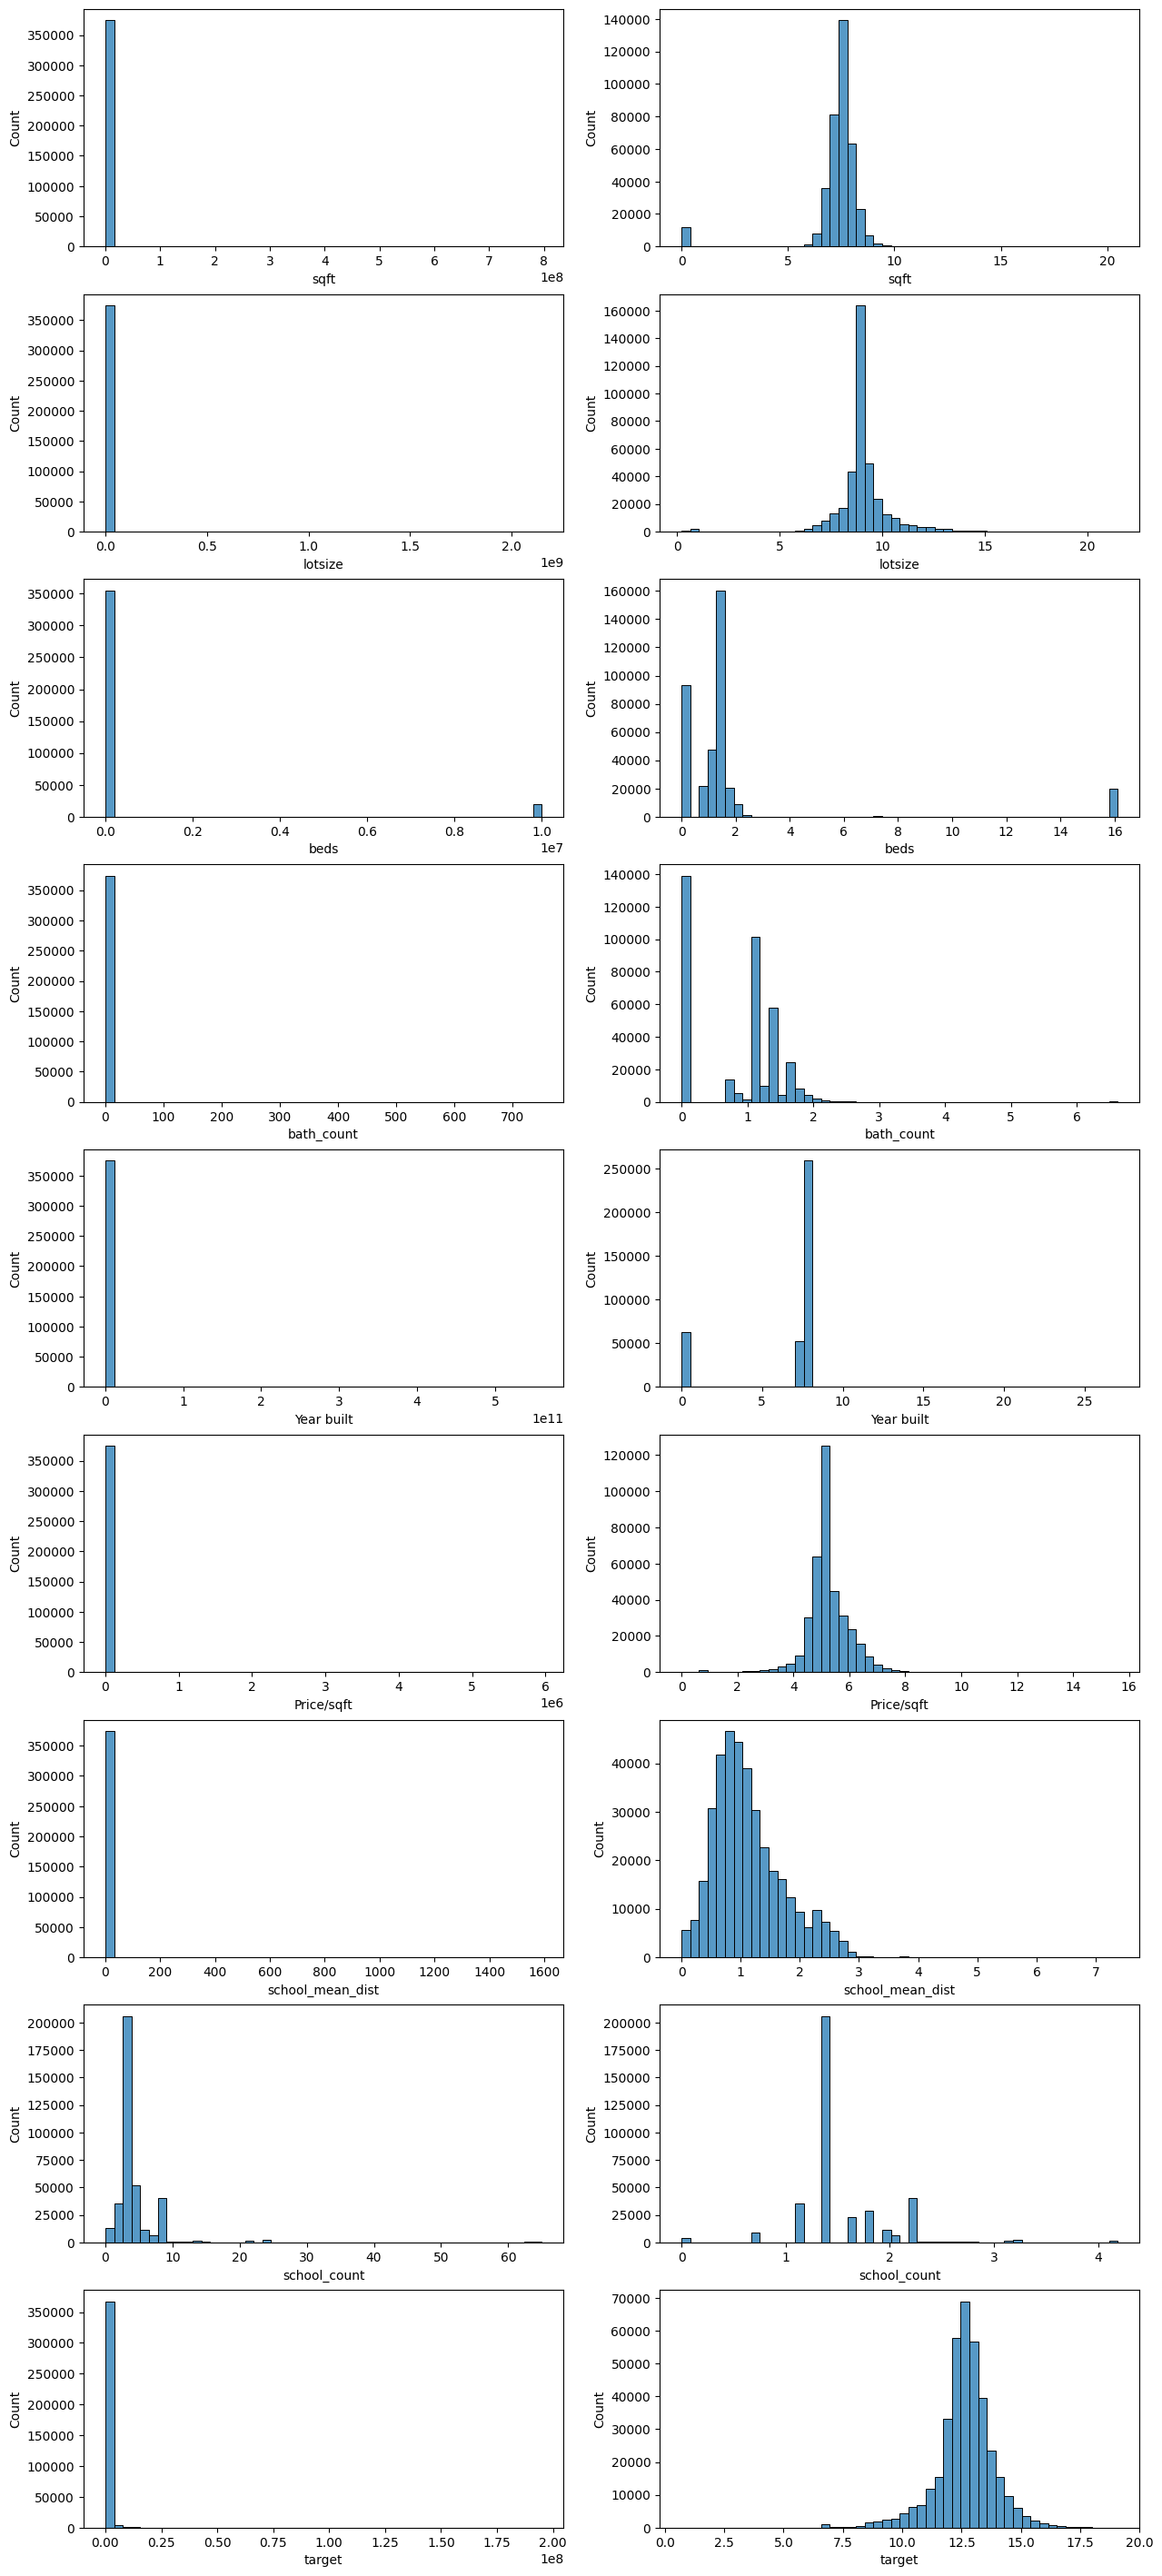

In [222]:
fig, axes = plt.subplots(len(col_list), 2, figsize=(15, len(col_list)*4))

str_ = 0
col_ = 0

for el in col_list:
    col_ = 0
    #гистограмма исходного признака
    histplot = sns.histplot(data[el], bins=50, ax=axes[str_][col_])
    col_ = 1
    
    #гистограмма в логарифмическом масштабе
    log_sqft= np.log(data[el] + 1)
    histplot = sns.histplot(log_sqft , bins=50, ax=axes[str_][col_])
    str_ += 1

Распределение признаков относительной стоимости недвижимости и среднего расстояния до школы не вызывает вопросов. Остольные признаки поблежат обработке

_Данные о площади_

In [223]:
median_sqft = data[data['sqft'] > 0]['sqft'].median()
data['sqft'] = data['sqft'].apply(lambda x: median_sqft if x == 0 else x)

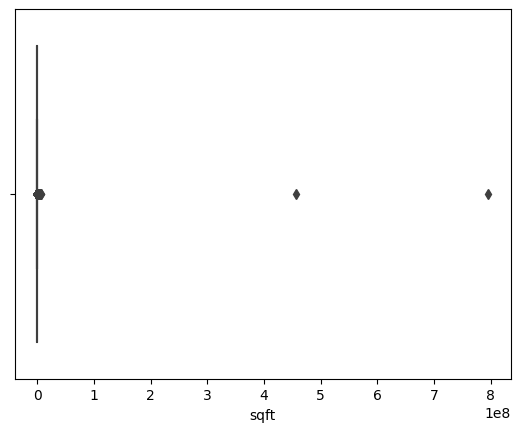

In [224]:
boxplot = sns.boxplot(data=data, x='sqft');


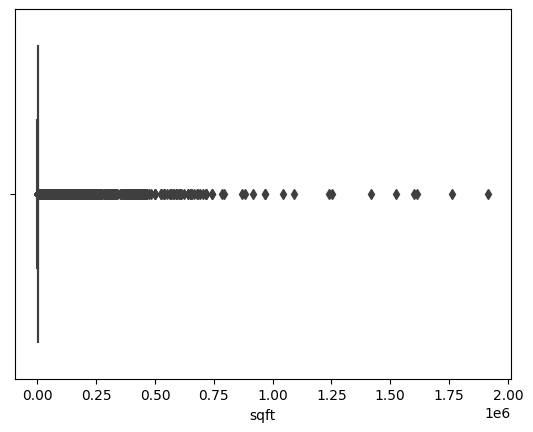

In [225]:
data = data[data['sqft'] < 2e6]
data = data[data['sqft'] > 0]
boxplot = sns.boxplot(data=data, x='sqft');

_Данные о придомовой площади_

In [226]:
median_lotsize = data[data['lotsize'] > 0]['lotsize'].median()
data['lotsize'] = data['lotsize'].apply(lambda x: median_lotsize if x == 0 else x)

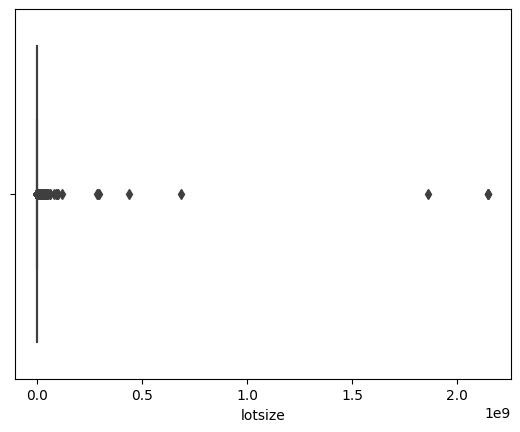

In [227]:
boxplot = sns.boxplot(data=data, x='lotsize');

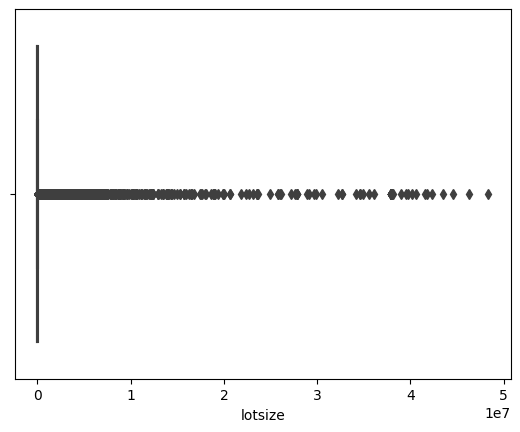

In [228]:
data = data[data['lotsize'] < 0.5e8]
data = data[data['lotsize'] > 0]
boxplot = sns.boxplot(data=data, x='lotsize');

Целевой признак

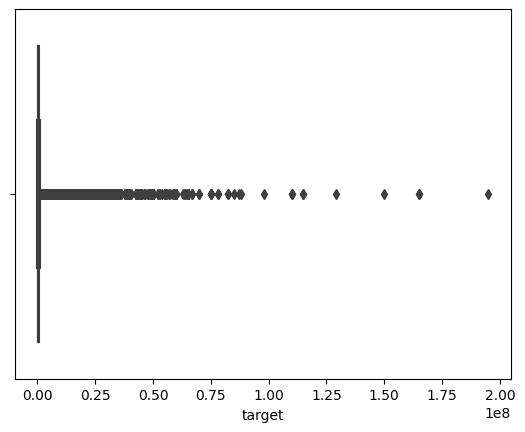

In [229]:
boxplot = sns.boxplot(data=data, x='target');

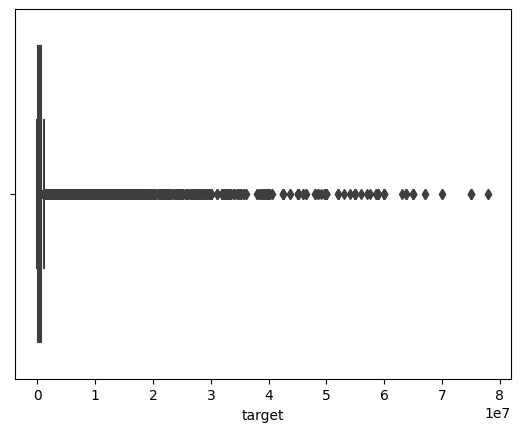

In [230]:
data = data[data['target'] < 0.8e8]
data = data[data['target'] > 0]
boxplot = sns.boxplot(data=data, x='target');

_Данные о спальнях_

Данные о спальнях не могут быть распределены нормалььно, потому что в большинстве данных отсутствуют отдельные спальни после заполнения пропусков. Поэтому выбросы в этих данных обработем вручную. Для этого посмотрим коробчатую диаграмму.

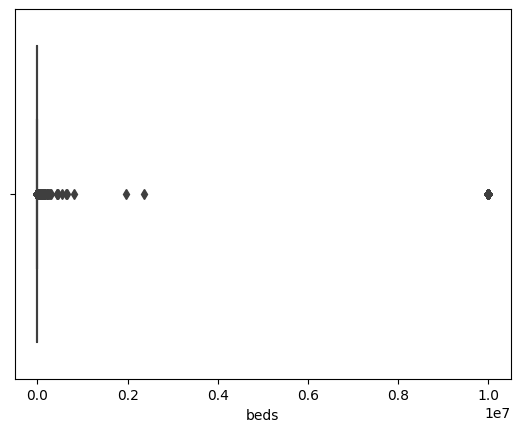

In [231]:
boxplot = sns.boxplot(data=data, x='beds');

Избавимся от данных, в которых спален больше 60

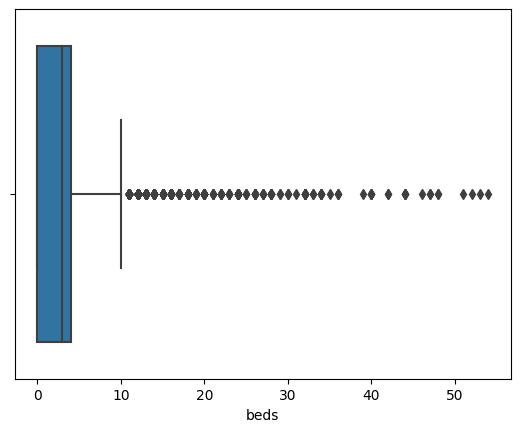

In [232]:
data = data[data['beds'] < 60]
boxplot = sns.boxplot(data=data, x='beds');

_Данные о ванных_

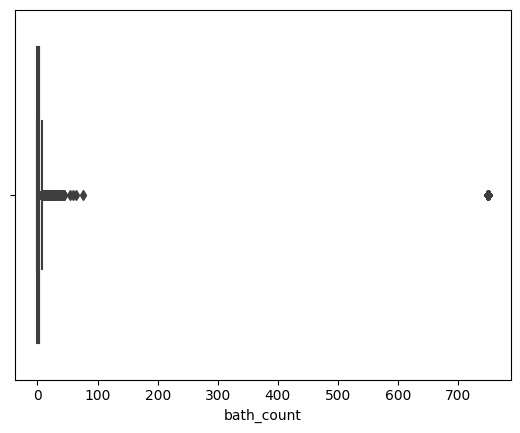

In [233]:
boxplot = sns.boxplot(data=data, x='bath_count');

Исключим данные, в которых более 50 ванных

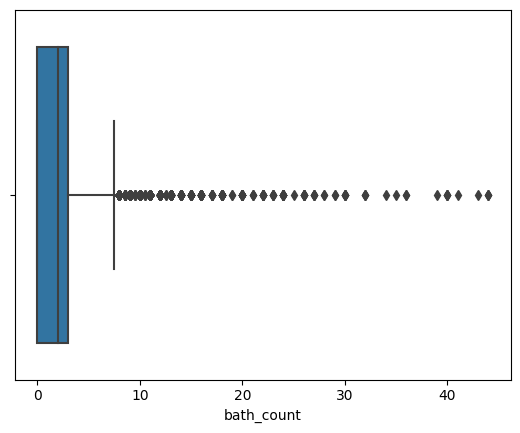

In [234]:
data = data[data['bath_count'] < 50]
boxplot = sns.boxplot(data=data, x='bath_count');

_Данные о годе постройки_

В этих данных будем следовать логике по поиску выбросов данных в спальнях

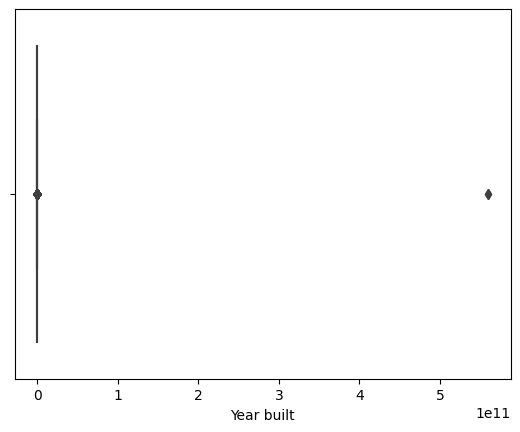

In [235]:
boxplot = sns.boxplot(data=data, x='Year built');

In [236]:
median_year = data[data['Year built'] > 0]['Year built'].median()
data['Year built'] = data['Year built'].apply(lambda x: median_year if x == 0 else x)

Исключим из признака даты превышающие текущий год и объявления с домами постройки ранее 1500 года

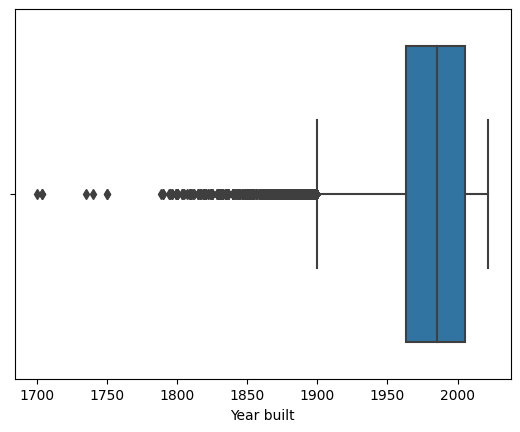

In [237]:
data = data[data['Year built'] > 1500.0]
data = data[data['Year built'] < 2023.0]
boxplot = sns.boxplot(data=data, x='Year built');

_Данные о количестве школ_

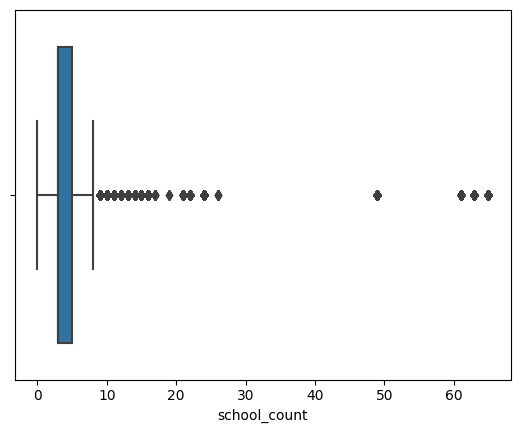

In [238]:
boxplot = sns.boxplot(data=data, x='school_count');

исключим объявления, в коротых более 40 школ

In [239]:
data = data[data['school_count'] < 40]

## 6. Исследование данных #

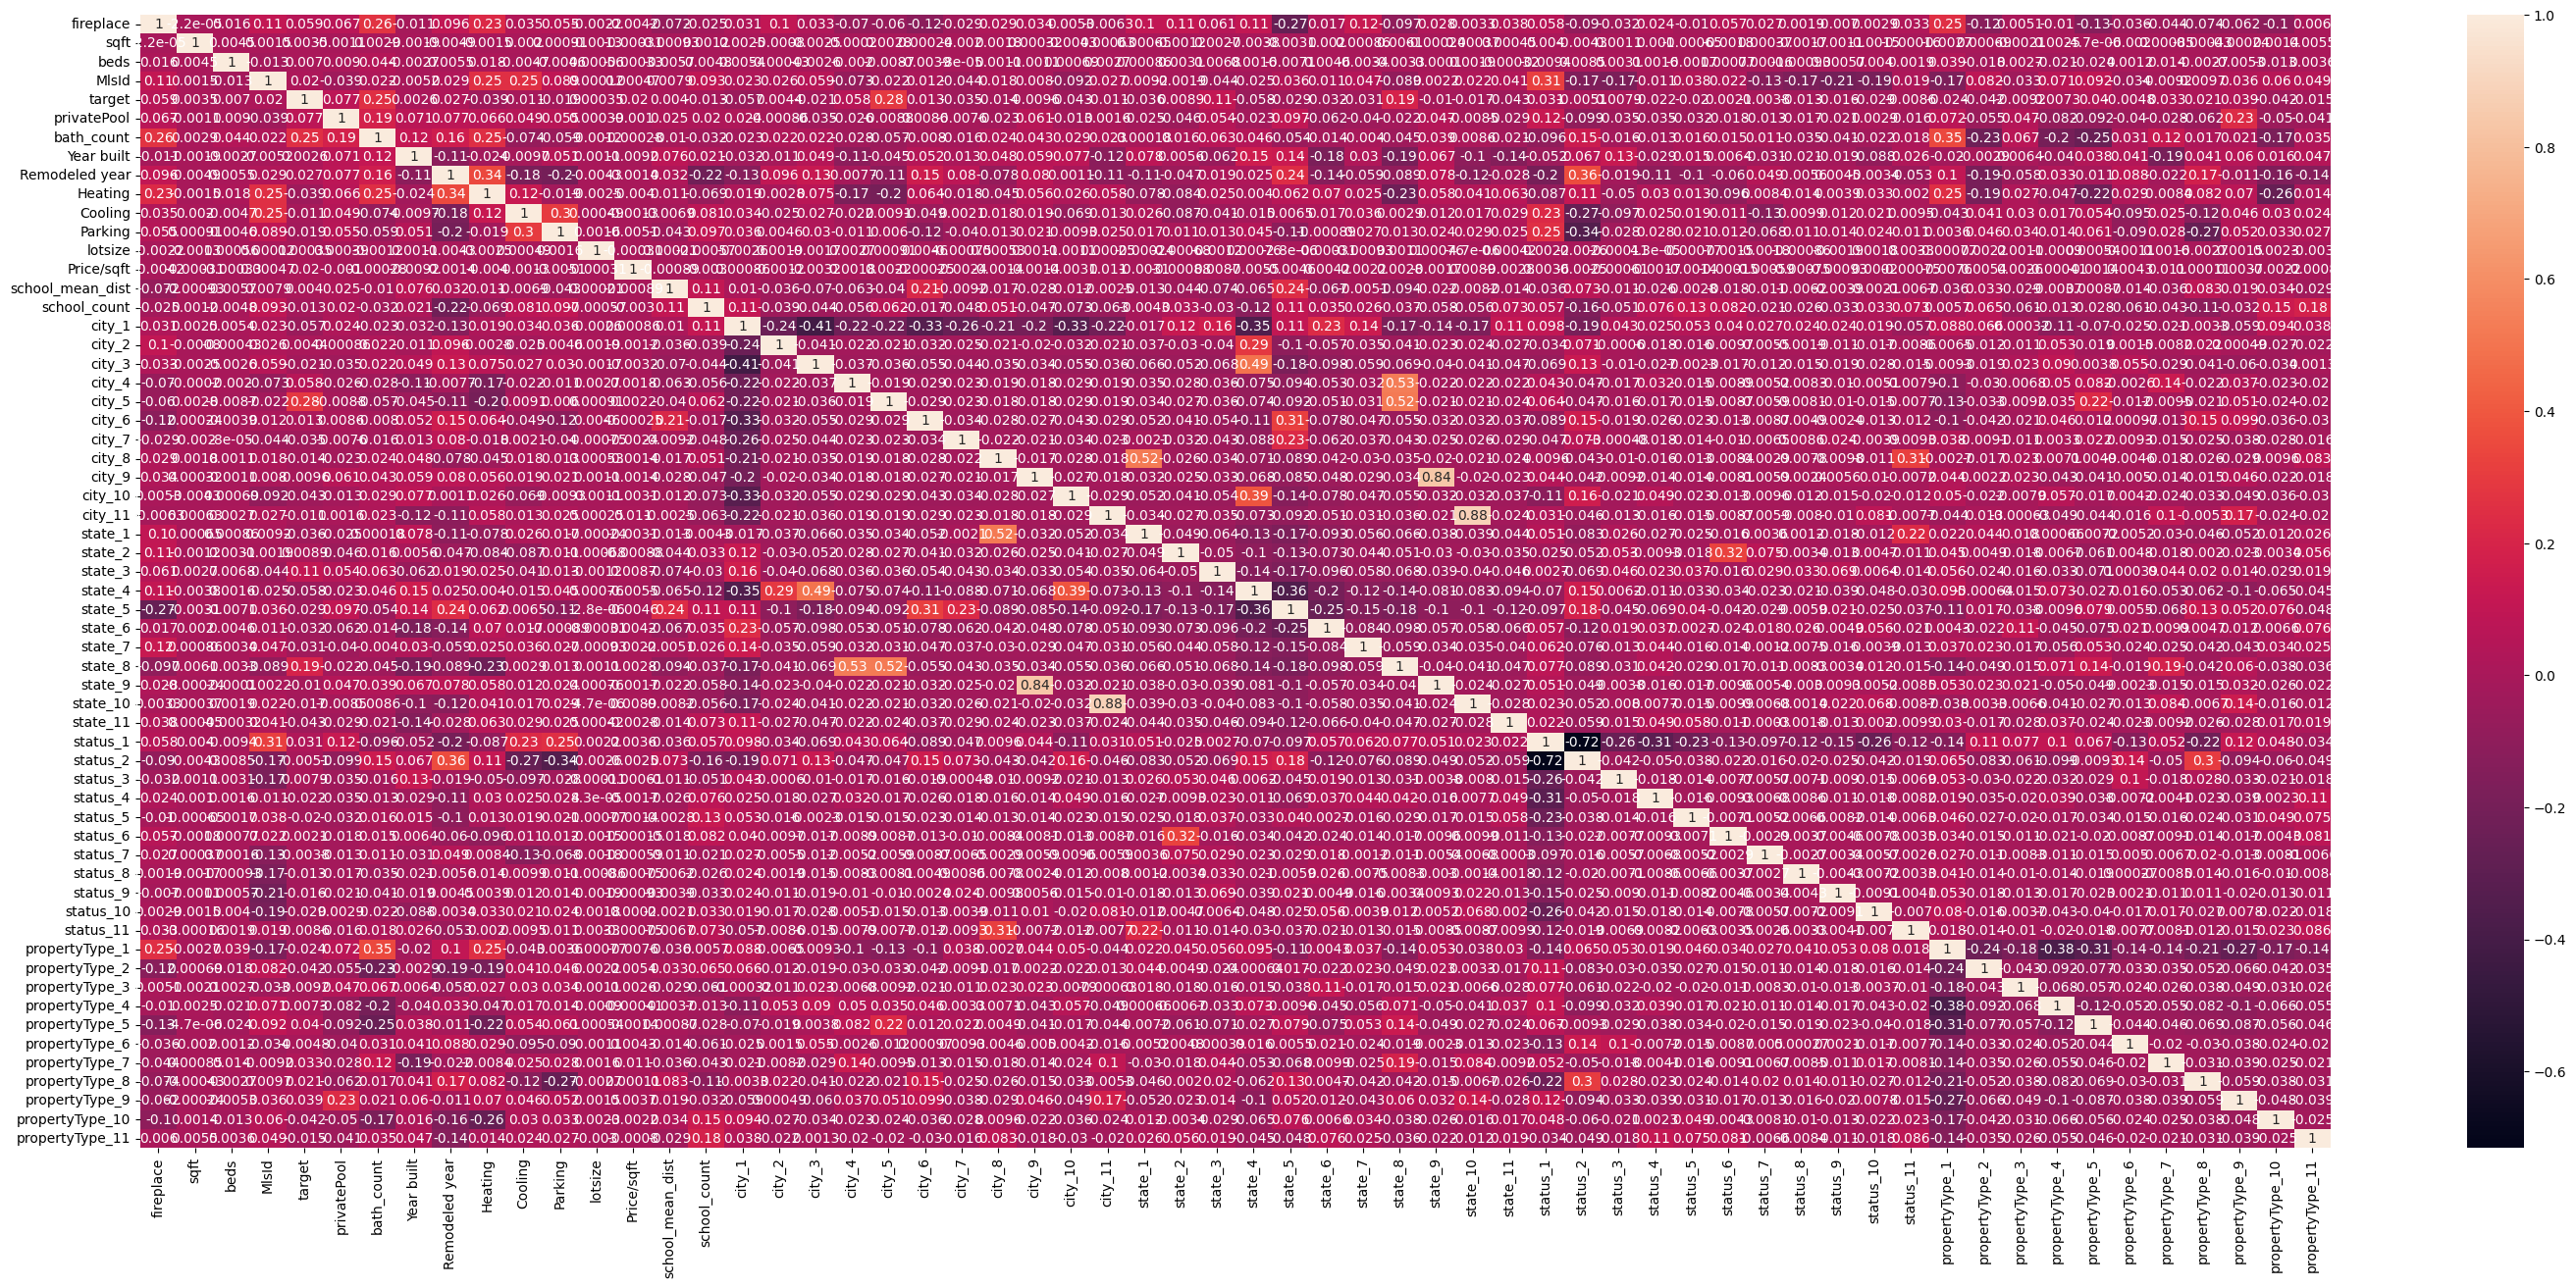

In [240]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(36, 15))
sns.heatmap(data.corr(), annot=True);
plt.savefig('heatmap.png')

In [241]:
data.describe()

,fireplace,sqft,beds,MlsId,target,privatePool,bath_count,Year built,Remodeled year,Heating,...,propertyType_2,propertyType_3,propertyType_4,propertyType_5,propertyType_6,propertyType_7,propertyType_8,propertyType_9,propertyType_10,propertyType_11
count,351503.000000,3.515030e+05,351503.000000,351503.000000,3.515030e+05,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000,...,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000,351503.000000
mean,0.266854,2.764350e+03,2.374150,0.893748,6.424286e+05,0.077092,1.718515,1980.423447,0.471009,0.696390,...,0.055095,0.030734,0.126750,0.092634,0.018575,0.020461,0.044369,0.069396,0.029399,0.020128
std,0.442316,1.547809e+04,1.902849,0.308161,1.669774e+06,0.266737,1.720469,30.569538,0.499160,0.459817,...,0.228166,0.172596,0.332693,0.289919,0.135017,0.141570,0.205915,0.254127,0.168924,0.140438
min,0.000000,1.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000,1700.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.376000e+03,0.000000,1.000000,1.887970e+05,0.000000,0.000000,1963.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.800000e+03,3.000000,1.000000,3.220000e+05,0.000000,2.000000,1985.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.450000e+03,4.000000,1.000000,5.850000e+05,0.000000,3.000000,2005.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.916640e+06,54.000000,1.000000,7.800000e+07,1.000000,44.000000,2022.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Из сильно коррелирующих признаков - статус 1 и статус 3, избавимся от последнего

In [242]:
data = data.drop(columns=['status_3'])

## 7. Создание модели

### 7.1. Модель линейной регрессии

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков) и столбец правильных ответов y

In [243]:
X = data.drop('target', axis=1)
y = data['target']

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [244]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (281202, 58)
Test shape: (70301, 58)


Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество

Заранее создадим функцию, которая будет расчитывать метрики:

1. MSE - среднеквадратичная ошибка
2. К2 - коэффициент детерминации

**Масштабирование данных**

In [245]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Модель линейной регрессии**

In [246]:
#Инициализируем объект класса линейная регрессия
lr_model = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr_model.fit(X_train_scaled, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

#Выводим результирующие метрики
print('MSE train: ', metrics.mean_squared_error(y_train, y_train_pred))
print('R2 train: ', metrics.r2_score(y_train, y_train_pred))
print('MSE test: ', metrics.mean_squared_error(y_test, y_test_pred))
print('R2 test: ', metrics.r2_score(y_test, y_test_pred))

MSE train:  2266153390806.5405
R2 train:  0.19043252100230146
MSE test:  2209868007298.0444
R2 test:  0.19459096564313716


Отбираем лучшие признаки, посмотрим, как они влияют на качество модели

In [247]:
list_k = list()
list_mse_train = list()
list_mse_test = list()
list_r2_train = list()
list_r2_test = list()

for i in (5, 10, 15, 20, 25, 30, 35, 40):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
    
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train, y_train)
 
    features = selector.get_feature_names_out()
    
    #Создаем объект для min-max нормализации
    scaler = preprocessing.MinMaxScaler()
    #Вычисляем параметры для нормализации - min и max для каждого столбца
    scaler.fit(X_train[features])
    #Производим преобразование для каждой из выборок
    X_train_scaled = scaler.transform(X_train[features])
    X_test_scaled = scaler.transform(X_test[features])
    
    lr_model = linear_model.LinearRegression()
    #Обучаем модель - ищем параметры
    lr_model.fit(X_train_scaled, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = lr_model.predict(X_train_scaled)
    y_test_pred = lr_model.predict(X_test_scaled)
    
    list_k.append(i)
    list_mse_train.append(metrics.mean_squared_error(y_train, y_train_pred))
    list_mse_test.append(metrics.mean_squared_error(y_test, y_test_pred))
    list_r2_train.append(metrics.r2_score(y_train, y_train_pred))
    list_r2_test.append(metrics.r2_score(y_test, y_test_pred))   

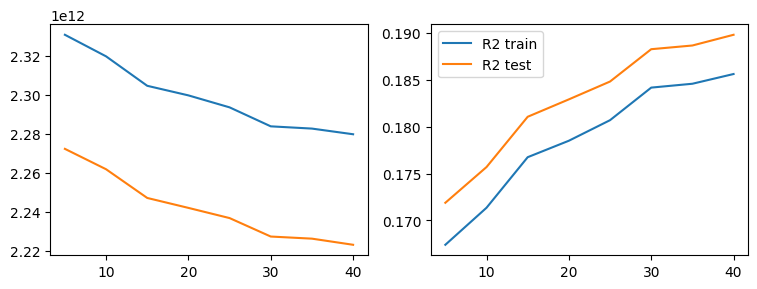

In [248]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))

ax[0].plot(list_k, list_mse_train, label = 'MSE train')
ax[0].plot(list_k, list_mse_test, label = 'MSE test')
ax[1].plot(list_k, list_r2_train, label = 'R2 train')
ax[1].plot(list_k, list_r2_test, label = 'R2 test')

plt.legend()
plt.show()

Наибольшее количество признаков приводит к наименьшей квадратичной ошибке и к наивысшему коэффициенту детерминации

### 7.2. Модель полиномиальной регрессии

In [249]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
lr_model_poly = linear_model.LinearRegression()
lr_model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = lr_model_poly.predict(X_train_poly)
y_test_pred_poly = lr_model_poly.predict(X_test_poly)

print('MSE train poly: ', metrics.mean_squared_error(y_train, y_train_pred_poly))
print('R2 train poly: ', metrics.r2_score(y_train, y_train_pred_poly))
print('MSE test poly: ', metrics.mean_squared_error(y_test, y_test_pred_poly))
print('R2 test poly: ', metrics.r2_score(y_test, y_test_pred_poly))

MSE train poly:  1594122228933.973
R2 train poly:  0.4305109621758867
MSE test poly:  2.276588657288338e+26
R2 test poly:  -82972605876866.3


При использовании полиномиальной регрессии модель переобучается.

### 7.3. Модель случайного леса и оптимизация гиперпараметров

In [250]:
#Создаем объект класса дерево решений
dt = ensemble.RandomForestRegressor(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.mean_squared_error(y_test, y_test_pred)))
print('Test: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))

Test: 967021657992.27
Test: 242774.32


Оптимизация гиперпараметров

In [251]:
random_state = 42

In [252]:
def optuna_rf(trial, cv=5):
  '''
    Настройка оптимизации гиперпараметров для алгоритма случайного леса (метод Optuna).
  '''
      
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="r2", n_jobs=-1).mean()
  # score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [253]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)


[I 2023-10-20 16:35:15,538] A new study created in memory with name: RandomForestRegressor
[I 2023-10-20 16:38:22,703] Trial 0 finished with value: 0.6239994213886261 and parameters: {'n_estimators': 114, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6239994213886261.
[I 2023-10-20 16:43:15,738] Trial 1 finished with value: 0.6181479586593721 and parameters: {'n_estimators': 198, 'max_depth': 12, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6239994213886261.
[I 2023-10-20 16:47:31,233] Trial 2 finished with value: 0.6276253889297572 and parameters: {'n_estimators': 150, 'max_depth': 16, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6276253889297572.
[I 2023-10-20 16:51:45,156] Trial 3 finished with value: 0.6312403243725256 and parameters: {'n_estimators': 117, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.6312403243725256.
[I 2023-10-20 16:57:16,148] Trial 4 finished with value: 0.6310649041685525 and parameters: {'n_

In [254]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("r2_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 149, 'max_depth': 28, 'min_samples_leaf': 2}
r2_score на обучающем наборе: 0.63


In [255]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=random_state)

model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
r2_Forest_optuna = metrics.r2_score(y_test, y_test_pred)
print('r2_score на тестовом наборе: {:.2f}'.format(r2_Forest_optuna))

r2_score на тестовом наборе: 0.65


In [256]:
print('y_test ', y_test.max())
print('y_test_pred ', y_test_pred.max())

y_test  78000000.0
y_test_pred  53979571.26877596


In [257]:
print('r2 test: ', metrics.r2_score(y_test, y_test_pred))
print('mae test: ', metrics.mean_absolute_error(y_test, y_test_pred))
print('mse test: ', metrics.mean_squared_error(y_test, y_test_pred))

r2 test:  0.6525948061505589
mae test:  237114.5778704474
mse test:  953204633556.2855


In [258]:
optuna.visualization.plot_optimization_history(study, target_name="r2_score")

In [259]:
optuna.visualization.plot_param_importances(study, target_name="r2_score")

## 8. Заключение

В результате работы написан код обработки даннх недвижимости (обработка пропусков, проектирование признако и избавление от выбросов). Также разработана модель предсказания цен на недвижимость. Модель еще требует доработки. Несмотря на достаточно высокий коэффициент детерминации дисперсия цены высока.